In [13]:
from math import isnan
from functools import total_ordering
import calendar
import zipfile
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from datetime import datetime
import datetime
import warnings
warnings.filterwarnings('ignore')

In [14]:
data = pd.read_csv('MSFT.csv', sep=",").filter(['UnderlyingPrice', 'Type', 'Expiration',
                   'DataDate', 'Strike', 'Last', 'Bid', 'Ask', 'Volume', 'OpenInterest', 'IV', 'Delta', 'Gamma',
                   'Theta', 'Vega'])

In [15]:
data['Expiration'] = pd.to_datetime(data['Expiration'])
data['DataDate'] = pd.to_datetime(data['DataDate'])

In [16]:
#data = data.drop_duplicates(subset='DataDate', keep='first').filter(['DataDate', 'UnderlyingPrice'])

In [17]:
#data = data.set_index('DataDate')

In [18]:
#data.plot()
#plt.title('Spot Prices for 5 years')
#plt.show()

In [19]:
df_call = data.loc[data['Type'] == "put"]

In [20]:
def calculate_mean_greeks(df, max_days, min_count = 100):
    greeks = {}
    for i in range(1, max_days + 1):
        frame = df[df.index.isin([i], level='Days')]
        count = frame.Delta.count()
        if count < min_count:
            continue
        delta = frame.Delta.mean()
        gamma = frame.Gamma.mean()
        theta = frame.Theta.mean()
        vega = frame.Vega.mean()
        greeks[i] = [delta, gamma, theta, vega, count]

    columns = ['Delta', 'Gamma', 'Theta', 'Vega', 'Count']
    return pd.DataFrame.from_dict(greeks, orient='index', columns=columns)

def plot_results(df):
    fig, ax = plt.subplots(nrows=2, ncols=2)
    columns = ['Delta', 'Gamma', 'Theta', 'Vega']
    fig.set_size_inches(20, 11)
    i = 0
    for row in ax:
        for col in row:
            name = columns[i]
            col.plot(df[name])
            col.set_title(name)
            col.invert_xaxis()
            i = i + 1

    plt.show()


def select_closest_dn_option_max_expiration_days(df):
    df['Days'] = (df['Expiration'] - df['DataDate']).astype('timedelta64[D]').astype(int)
    df2 = df.groupby('DataDate').apply(lambda x: x.groupby('Days').apply(lambda g: g.iloc[(g['Delta'] + 0.5).abs().argsort()[:1]]))
    max_expiration_days = df2.loc[df2['Days'].idxmax()]['Days']
    print(f'Max days option expiration is {max_expiration_days}')
    return df2, max_expiration_days
    # return calculate_mean_greeks(df2, max_days)


def full_analysis(df, min_count = 100):
    df_dn_options, max_days = select_closest_dn_option_max_expiration_days(df)
    df_greeks = calculate_mean_greeks(df_dn_options, max_days, min_count)
    plot_results(df_greeks)
    return df_greeks

Max days option expiration is 945


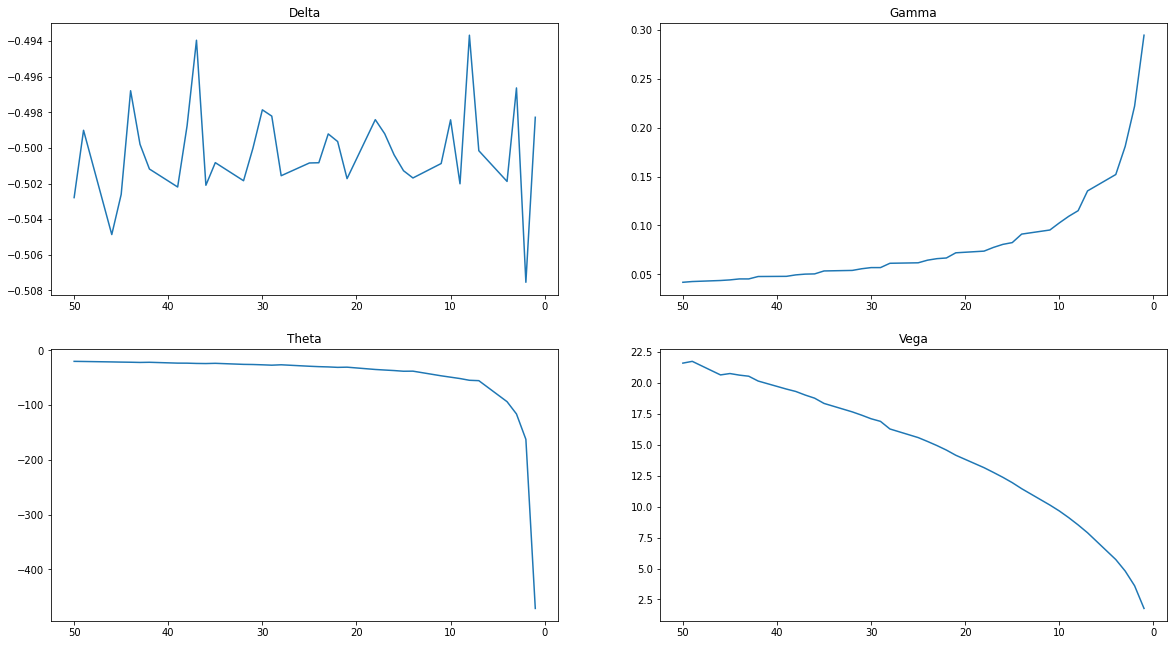

,Delta,Gamma,Theta,Vega,Count
1,-0.498279,0.294820,-471.246457,1.775723,263
2,-0.507551,0.222228,-162.584287,3.606878,266
3,-0.496629,0.180928,-116.271293,4.796687,267
4,-0.501883,0.152110,-93.843192,5.726809,235
7,-0.500158,0.135322,-55.477191,7.890912,262
8,-0.493666,0.115070,-54.787073,8.524405,263
9,-0.502017,0.109292,-51.623391,9.111819,266
10,-0.498422,0.102539,-49.125730,9.652752,267
11,-0.500877,0.095281,-46.630491,10.129933,235
14,-0.501689,0.091081,-38.136348,11.452451,261


In [21]:
full_analysis(df_call)

In [22]:
df_call['Weekday'] = df_call['DataDate'].dt.day_name()
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

Analysis for Monday
Max days option expiration is 935


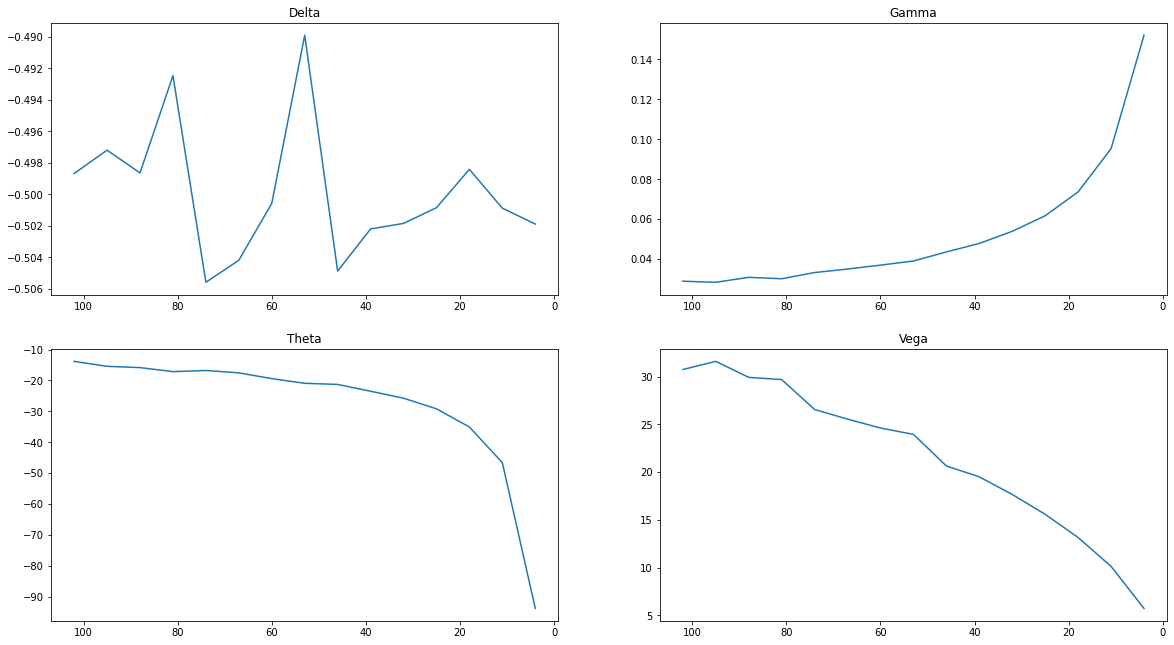

Analysis for Tuesday
Max days option expiration is 941


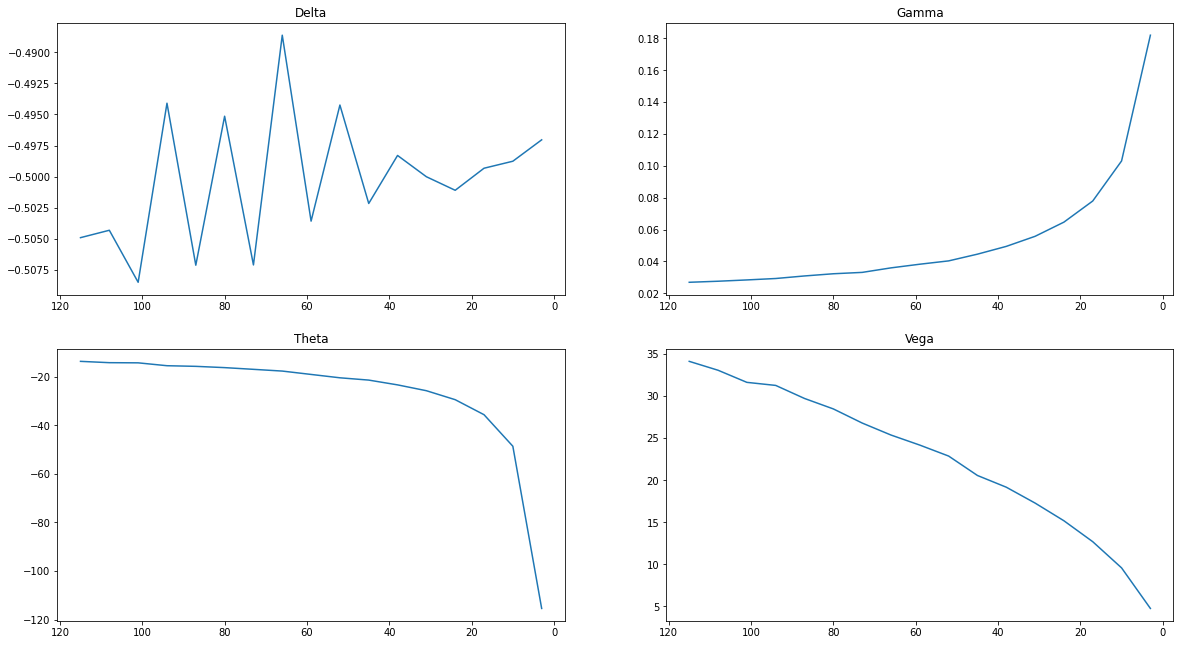

Analysis for Wednesday
Max days option expiration is 940


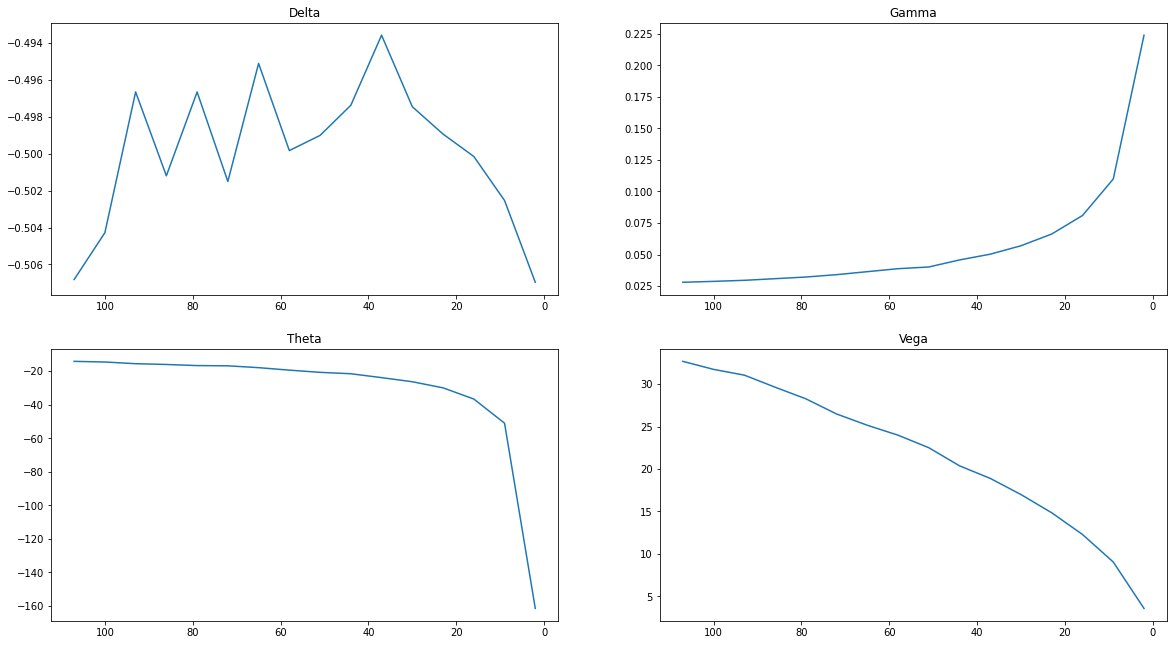

Analysis for Thursday
Max days option expiration is 939


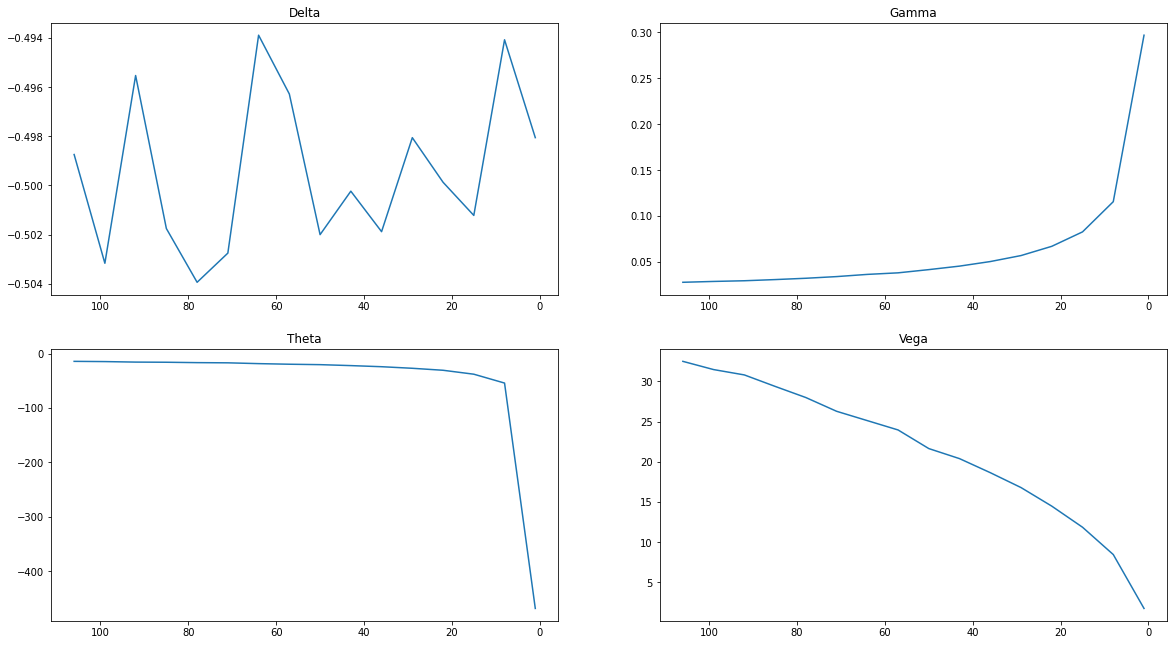

Analysis for Friday
Max days option expiration is 945


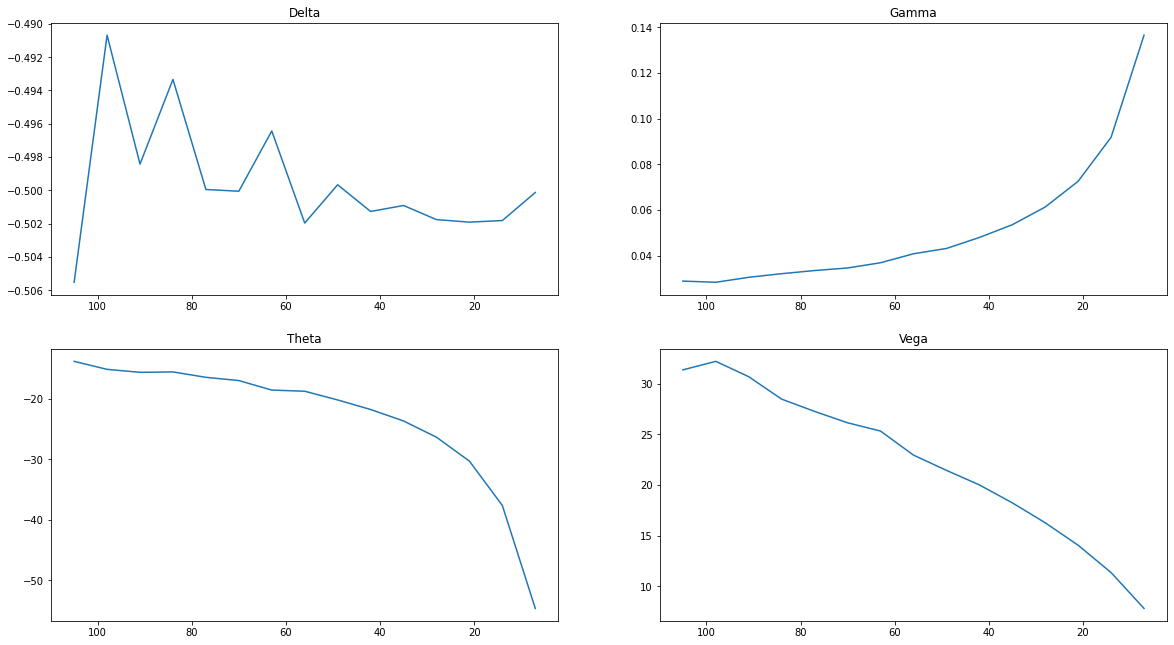

In [23]:
df_call.drop_duplicates(subset='Weekday', keep='first').filter(['Weekday'])
greeks = {}
for week_day in week_days:
    df_week_day = df_call.loc[df_call['Weekday'] == week_day]
    print(f'Analysis for {week_day}')
    greeks[week_day] = full_analysis(df_week_day, min_count=50)


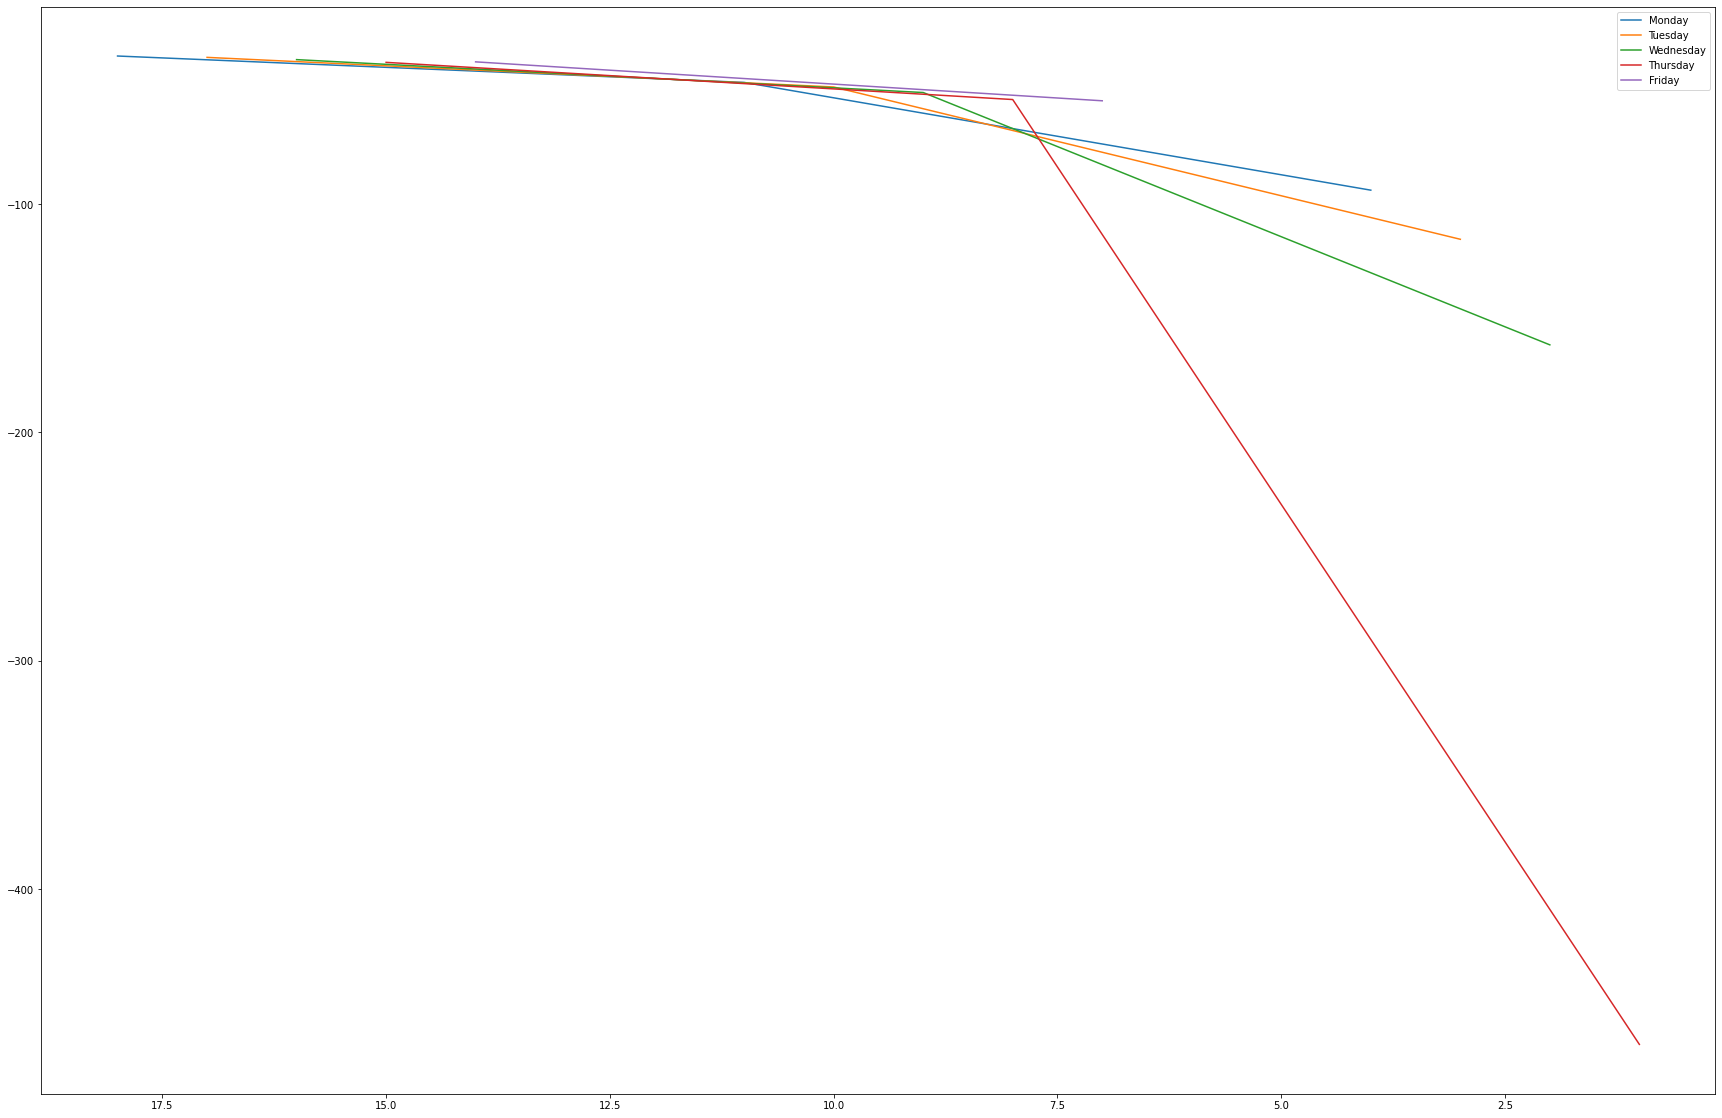

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(30, 20)
plt.gca().invert_xaxis()
for week_day in week_days:
    df = greeks[week_day]
    df = df[df.index < 20]
    week_df = df.filter(['Theta']).rename(columns={'Theta': week_day})
    week_df.plot(ax=ax)

plt.show()